In [27]:
import os
import json
import torch
import torch.nn.functional as F
import random
import time
from transformers import RobertaTokenizer, RobertaModel
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
from sklearn.metrics import accuracy_score, f1_score, recall_score,precision_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier as SklearnMLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import numpy as np
import datetime
import time
from tqdm import tqdm
import random

In [28]:
### 选择gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [29]:
#### 参数配置
projectionHeadEpoch=30                   
beforeProjectionEpoch=30                  
afterProjectionEpoch=30
Temperature=0.2
projectionHeadPatience=2
beforeProjectionPatience=2
afterProjectionPatience=2
index=5        
lang=3
Trainsize=10
lr1=3e-6
lr2=1e-6
lr3=1e-6
Pre_fig_tilte='20241024'
ProjectionBatchSize=1                   
BatchSize=64
ExpertsNum=8

In [30]:
# 加载模型和tokenizer
modelType=['codebert-base','codeExecutor','CodeReviewer','graphCodeBert','longcoder-base','unixcoder']
modelPath='../../../model/'+modelType[index]+'/'
tokenizer = AutoTokenizer.from_pretrained(modelPath)
model = AutoModel.from_pretrained(modelPath).to(device)
print(model)

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(51416, 768, padding_idx=1)
    (position_embeddings): Embedding(1026, 768, padding_idx=1)
    (token_type_embeddings): Embedding(10, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (drop

In [6]:
# 加载并处理样本数据
langType=['code_pairs_cpp_python.jsonl','code_pairs_java_c.jsonl','code_pairs_java_cs.jsonl','code_pairs_java_python.jsonl']
langPath='../../../Datasets/'+langType[lang]
def load_samples_from_jsonl(file_path, max_samples=Trainsize):
    samples = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            record = json.loads(line.strip())
            samples.append(record)
            if len(samples) >= max_samples:
                break
    return samples

samples = load_samples_from_jsonl(langPath)
print(langType[lang])

code_pairs_java_python.jsonl


In [7]:
# 对样本数据进行编码
def encode_sample(sample, tokenizer, model, device, max_length=512):
    code_inputs = tokenizer(sample['code'], return_tensors='pt', padding='max_length', truncation=True,
                            max_length=max_length).to(device)
    with torch.no_grad():
        code_embedding = model(**code_inputs).last_hidden_state.mean(dim=1).cpu()

    positive_embeddings = []
    for positive_sample in sample['positive']['code_positive']:
        pos_inputs = tokenizer(positive_sample['code'], return_tensors='pt', padding='max_length', truncation=True,
                               max_length=max_length).to(device)
        with torch.no_grad():
            pos_embedding = model(**pos_inputs).last_hidden_state.mean(dim=1).cpu()
        positive_embeddings.append(pos_embedding)

    negative_embeddings = []
    for negative_sample in sample['negative']['code_negative']:
        neg_inputs = tokenizer(negative_sample['code'], return_tensors='pt', padding='max_length', truncation=True,
                               max_length=max_length).to(device)
        with torch.no_grad():
            neg_embedding = model(**neg_inputs).last_hidden_state.mean(dim=1).cpu()
        negative_embeddings.append(neg_embedding)

    return {
        'code_embedding': code_embedding,
        'positive_embeddings': positive_embeddings,
        'negative_embeddings': negative_embeddings
    }
encoded_samples = [encode_sample(sample, tokenizer, model, device) for sample in samples]

In [31]:
class CombinedProjectionHead(nn.Module):
    def __init__(self, input_dim):
        super(CombinedProjectionHead, self).__init__()
        self.fc1 = nn.Linear(input_dim, input_dim)
        self.selective_fc = nn.Linear(input_dim, input_dim)
        self.swish = nn.SiLU()
        self.control_weight = nn.Parameter(torch.ones(input_dim))  # 学习的权重参数
        self.fc2 = nn.Linear(input_dim, input_dim)
    def forward(self, x):
        # 第一个全连接层
        x = self.fc1(x)
        # 选择性激活部分
        selective_output = self.swish(self.selective_fc(x)) * x
        # 使用控制权重进行调整
        adjusted_output = selective_output * self.control_weight
        # 第二个全连接层
        output = self.fc2(adjusted_output)
        return output

class SimCLR(nn.Module):
    def __init__(self, input_dim=768):
        super(SimCLR, self).__init__()
        self.projection_head = CombinedProjectionHead(input_dim)

    def forward(self, x):
        return self.projection_head(x)

contrastive_model = SimCLR(input_dim=768).to(device)
optimizer = optim.AdamW(contrastive_model.parameters(), lr=lr1)

In [32]:
def simclr_contrastive_loss(anchor, positives, negatives, temperature=Temperature):
    anchor = F.normalize(anchor, dim=1)
    positives = [F.normalize(pos, dim=1) for pos in positives]
    negatives = [F.normalize(neg, dim=1) for neg in negatives]

    positive_loss = 0
    for pos in positives:
        pos_similarity = torch.exp(torch.mm(anchor, pos.t()) / temperature)
        neg_similarity = sum(torch.exp(torch.mm(anchor, neg.t()) / temperature) for neg in negatives)
        positive_loss += -torch.log(pos_similarity / (pos_similarity + neg_similarity)).mean()

    loss = positive_loss / len(positives)
    return loss

In [33]:
class CodeCloneDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        anchor = sample['code_embedding'].view(1, -1)  # 确保 anchor 是二维矩阵
        positives = [pos.view(1, -1) for pos in sample['positive_embeddings']]  # 确保 positives 是二维矩阵
        negatives = [neg.view(1, -1) for neg in sample['negative_embeddings']]  # 确保 negatives 是二维矩阵
        return anchor, positives, negatives

In [34]:
control_weights_history = []

In [35]:
###### 训练模型(MixCon_ProjectionHead)
def train_contrastive_model(encoded_samples, val_encoded_samples, contrastive_model, epochs=100, temperature=Temperature, patience=3):
    global control_weights_history
    train_dataset = CodeCloneDataset(encoded_samples)
    val_dataset = CodeCloneDataset(val_encoded_samples)
    
    train_dataloader = DataLoader(train_dataset, batch_size=ProjectionBatchSize, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=ProjectionBatchSize, shuffle=False)
    
    optimizer = torch.optim.Adam(contrastive_model.parameters(), lr=lr1)  # 假设使用Adam优化器
    
    contrastive_model.train()
    losses = []
    val_losses = []
    best_val_loss = float('inf')
    no_improvement_count = 0
    start_time = time.time()  # 记录训练开始时间
    
    for epoch in range(epochs):
        total_loss = 0
        contrastive_model.train()  # 设置模型为训练模式
        
        for i, (anchor, positives, negatives) in enumerate(train_dataloader):
            optimizer.zero_grad()
            anchor, positives, negatives = anchor.to(device), [pos.to(device) for pos in positives], [neg.to(device) for neg in negatives]
            anchor = contrastive_model(anchor)
            positives = [contrastive_model(pos) for pos in positives]
            negatives = [contrastive_model(neg) for neg in negatives]
            anchor = anchor.view(anchor.size(0), -1)  # 确保 anchor 是二维矩阵
            positives = [pos.view(pos.size(0), -1) for pos in positives]  # 确保 positives 是二维矩阵
            negatives = [neg.view(neg.size(0), -1) for neg in negatives]  # 确保 negatives 是二维矩阵
            loss = simclr_contrastive_loss(anchor, positives, negatives, temperature)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_train_loss = total_loss / len(train_dataloader)
        losses.append(avg_train_loss)
        print(f'Epoch {epoch + 1}, Train Loss: {avg_train_loss}', end=" ")
        
        # 记录权重
        current_control_weights = contrastive_model.projection_head.control_weight.detach().cpu().numpy()
        control_weights_history.append(current_control_weights)
        
        # 验证集评估
        contrastive_model.eval()  # 设置模型为评估模式
        total_val_loss = 0
        
        with torch.no_grad():
            for i, (anchor, positives, negatives) in enumerate(val_dataloader):
                anchor, positives, negatives = anchor.to(device), [pos.to(device) for pos in positives], [neg.to(device) for neg in negatives]
                anchor = contrastive_model(anchor)
                positives = [contrastive_model(pos) for pos in positives]
                negatives = [contrastive_model(neg) for neg in negatives]
                anchor = anchor.view(anchor.size(0), -1)  # 确保 anchor 是二维矩阵
                positives = [pos.view(pos.size(0), -1) for pos in positives]  # 确保 positives 是二维矩阵
                negatives = [neg.view(neg.size(0), -1) for neg in negatives]  # 确保 negatives 是二维矩阵
                val_loss = simclr_contrastive_loss(anchor, positives, negatives, temperature)
                total_val_loss += val_loss.item()
        
        avg_val_loss = total_val_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)
        print(f'Validation Loss: {avg_val_loss}')
        
        # 早停法逻辑
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            no_improvement_count = 0
        else:
            no_improvement_count += 1
            if no_improvement_count >= patience:
                print(f'Early stopping triggered after {epoch + 1} epochs.')
                break
        
        torch.cuda.empty_cache()
    
    end_time = time.time()  # 记录训练结束时间
    training_time = end_time - start_time  # 计算总训练时间
    return losses, val_losses, training_time

In [13]:
def evaluate_clones(samples, model, contrastive_model=None, mlp_model=None):
    model.eval()
    if contrastive_model:
        contrastive_model.eval()
    if mlp_model:
        mlp_model.eval()

    all_labels = []
    all_preds = []

    start_time = time.time()  # 记录预测开始时间

    for sample in samples:
        anchor = sample['code_embedding'].squeeze().to(device)  # 确保 anchor 是二维矩阵
        positives = [pos.squeeze().to(device) for pos in sample['positive_embeddings']]  # 确保 positives 是二维矩阵
        negatives = [neg.squeeze().to(device) for neg in sample['negative_embeddings']]  # 确保 negatives 是二维矩阵

        if contrastive_model:
            with torch.no_grad():
                anchor = contrastive_model(anchor)
                positives = [contrastive_model(pos) for pos in positives]
                negatives = [contrastive_model(neg) for neg in negatives]
                

        
        ######### 包含MLP作为克隆检测器
        if mlp_model:
            with torch.no_grad():
                for pos in positives:
                    output = mlp_model(anchor, pos)
                    all_labels.append(1)
                    all_preds.append(torch.argmax(output).item())
                for neg in negatives:
                    output = mlp_model(anchor, neg)
                    all_labels.append(0)
                    all_preds.append(torch.argmax(output).item())
        else:   ################ 不含MLP作为克隆检测器,直接用阈值判断
            for pos in positives:
                similarity = F.cosine_similarity(anchor, pos, dim=0).item()
                all_labels.append(1)
                all_preds.append(1 if similarity > 0.5 else 0)

            for neg in negatives:
                similarity = F.cosine_similarity(anchor, neg, dim=0).item()
                all_labels.append(0)
                all_preds.append(0 if similarity <= 0.5 else 1)

    end_time = time.time()  # 记录预测结束时间
    prediction_time = end_time - start_time  # 计算预测时间

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    precision=precision_score(all_labels,all_preds)
    return acc, f1, recall,precision, prediction_time

In [14]:
# 将数据集分为训练集和测试集
train_samples, remaining_samples = train_test_split(encoded_samples, test_size=0.4, random_state=42)
# 第二次分割：将剩余部分分为验证集和测试集
val_samples, test_samples = train_test_split(remaining_samples, test_size=0.5, random_state=42)

In [36]:
#### ProjectionHead训练模型

contrastive_losses,val_losses, contrastive_training_time =train_contrastive_model(
    train_samples,val_samples, 
    contrastive_model,
    projectionHeadEpoch,
    Temperature,
    projectionHeadPatience)

Epoch 1, Train Loss: 2.394636631011963 Validation Loss: 1.9155917167663574
Epoch 2, Train Loss: 2.265627125898997 Validation Loss: 1.8353316187858582
Epoch 3, Train Loss: 2.1490850249926248 Validation Loss: 1.757779836654663
Epoch 4, Train Loss: 2.037147283554077 Validation Loss: 1.6815339922904968
Epoch 5, Train Loss: 1.9233360489209492 Validation Loss: 1.6055686473846436
Epoch 6, Train Loss: 1.8090863227844238 Validation Loss: 1.5303357243537903
Epoch 7, Train Loss: 1.7035068074862163 Validation Loss: 1.456134557723999
Epoch 8, Train Loss: 1.5947355031967163 Validation Loss: 1.3834837675094604
Epoch 9, Train Loss: 1.4910092155138652 Validation Loss: 1.3120406866073608
Epoch 10, Train Loss: 1.3919209043184917 Validation Loss: 1.2433738112449646
Epoch 11, Train Loss: 1.295259714126587 Validation Loss: 1.1760523319244385
Epoch 12, Train Loss: 1.2039263745148976 Validation Loss: 1.111032247543335
Epoch 13, Train Loss: 1.1154568791389465 Validation Loss: 1.0485970973968506
Epoch 14, Train

In [16]:
contrastive_acc, contrastive_f1, contrastive_recall,contrastive_precision ,contrastive_prediction_time = evaluate_clones(test_samples, model, contrastive_model)
print(
    f'Contrastive Learning Embedding - ACC: {contrastive_acc},'
    f' F1: {contrastive_f1},'
    f' Recall: {contrastive_recall},'
    f'Precision:{contrastive_precision}'
)

Contrastive Learning Embedding - ACC: 0.75, F1: 0.6666666666666666, Recall: 0.5,Precision:1.0


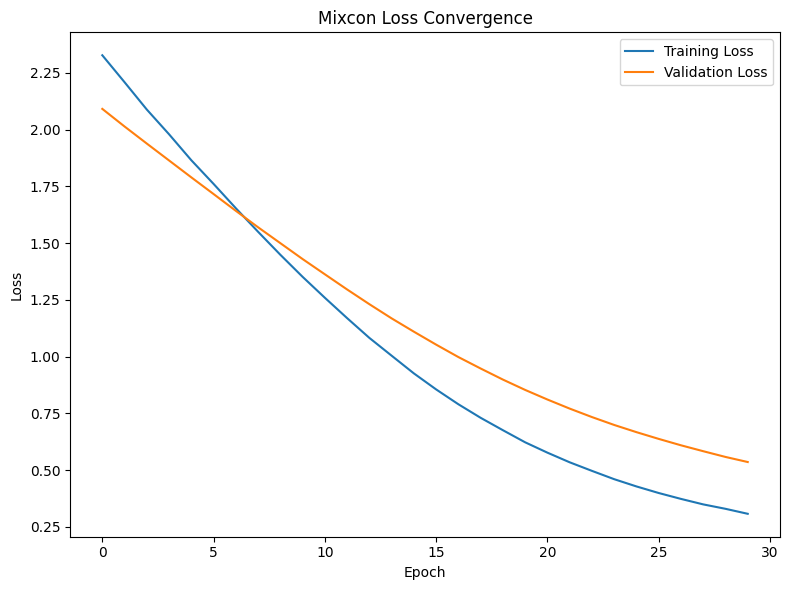

In [21]:
#### 绘制收敛图
plt.style.use('default')
plt.figure(figsize=(8, 6))
plt.plot(contrastive_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Mixcon Loss Convergence')
plt.legend(loc='upper right')  # 将图例放在左上角
plt.tight_layout()
plt.savefig(Pre_fig_tilte + 'Mixcon Loss Convergence' + ".png")
plt.show()

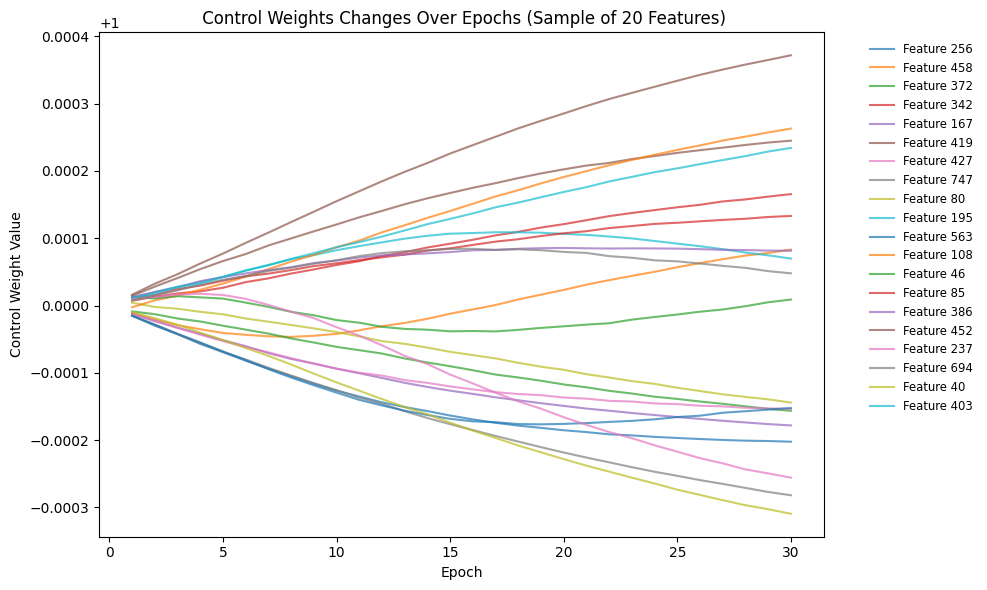

In [19]:
# 绘制控制权重的变化曲线
def plot_control_weights(control_weights_history, num_features_to_plot=20):
    plt.figure(figsize=(10, 6))
    num_epochs = len(control_weights_history)
    num_total_features = len(control_weights_history[0])

    # 随机选择 num_features_to_plot 个特征进行绘制
    sampled_features = random.sample(range(num_total_features), num_features_to_plot)

    # 绘制采样特征的控制权重变化
    for feature_idx in sampled_features:
        feature_weights = [epoch_weights[feature_idx] for epoch_weights in control_weights_history]
        plt.plot(range(1, num_epochs + 1), feature_weights, label=f'Feature {feature_idx + 1}', alpha=0.7)

    plt.xlabel('Epoch')
    plt.ylabel('Control Weight Value')
    plt.title(f' Control Weights Changes Over Epochs (Sample of {num_features_to_plot} Features)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1, fontsize='small', frameon=False)
    plt.tight_layout()
    plt.savefig(Pre_fig_tilte+'Control Weights Changes Over Epochs'+".png")
    plt.show()

# 绘制控制权重变化 (采样 20 个特征)
plot_control_weights(control_weights_history, num_features_to_plot=20)

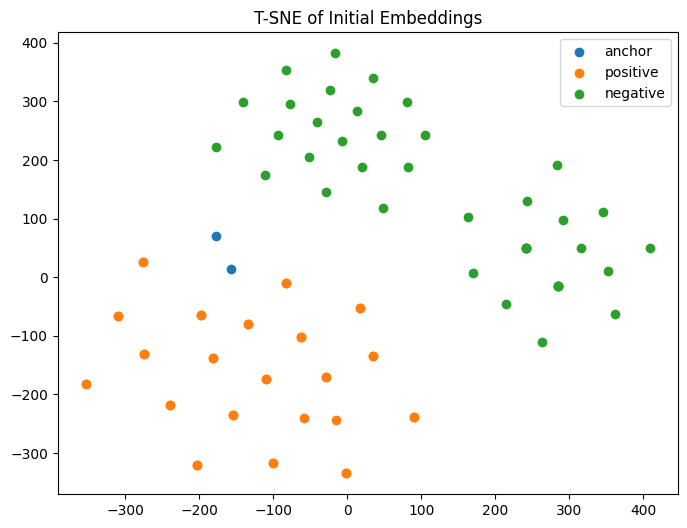

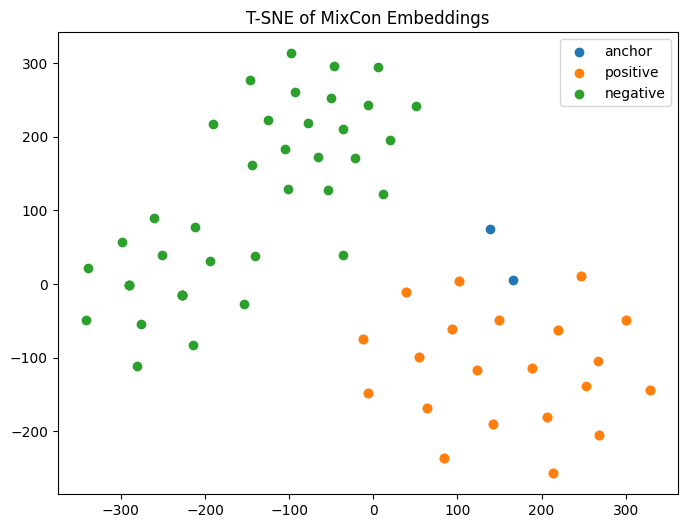

In [18]:
# 绘制T-SNE图
def plot_tsne(samples, contrastive_model=None, title=''):
    plt.style.use('default')
    embeddings = []
    labels = []
    cnt=0
    for sample in samples:
        anchor = sample['code_embedding'].squeeze().numpy()
        embeddings.append(anchor)
        labels.append('anchor')
        for pos in sample['positive_embeddings']:
            embeddings.append(pos.squeeze().numpy())
            labels.append('positive')
        for neg in sample['negative_embeddings']:
            embeddings.append(neg.squeeze().numpy())
            labels.append('negative')
        cnt+=1
        if cnt==2:
            break
    if contrastive_model:
        contrastive_model.eval()
        embeddings = contrastive_model(torch.tensor(embeddings).to(device)).cpu().detach().numpy()

    embeddings = np.array(embeddings)  # 确保 embeddings 是 NumPy 数组

    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(embeddings)

    plt.figure(figsize=(8, 6))
    for label in ['anchor', 'positive', 'negative']:
        idx = [i for i, lbl in enumerate(labels) if lbl == label]
        plt.scatter(tsne_results[idx, 0], tsne_results[idx, 1], label=label)
    plt.legend()
    plt.title(title)
    plt.savefig(time.time().__str__()+title+".png")
    plt.show()

# %%
# 绘制T-SNE图：对比学习前后的嵌入分布
plot_tsne(test_samples, title='T-SNE of Initial Embeddings')
plot_tsne(test_samples, contrastive_model, title='T-SNE of MixCon Embeddings')